Importuri & configurări

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, ConfusionMatrixDisplay,
    precision_recall_fscore_support, accuracy_score, brier_score_loss
)
from imblearn.over_sampling import SMOTE

import joblib
from joblib import dump

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.dpi"] = 120

Încărcarea datelor

In [ ]:
from google.colab import files

uploaded = files.upload()
if not uploaded:
    raise RuntimeError("Nu s-a încărcat niciun fișier. Re-rulează și selectează 'diabetes.csv'.")

csv_file = list(uploaded.keys())[0]
print(f"\nFișier încărcat: {csv_file}\n")

df = pd.read_csv(csv_file)
print("Dimensiune dataset:", df.shape)
df.head()

Saving diabetes.csv to diabetes.csv

Fișier încărcat: diabetes.csv

Dimensiune dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Info & statistici rapide

In [ ]:
print("Tipuri de date și non-null counts:")
display(df.info())

print("\nStatistici descriptive:")
display(df.describe())

suspect_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
print("\nZero-uri suspecte:")
for c in suspect_cols:
    if c in df.columns:
        print(f" - {c}: {(df[c]==0).sum()}")

print("\nDistribuția Outcome:")
display(df['Outcome'].value_counts().to_frame('count'))

Tipuri de date și non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None


Statistici descriptive:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Zero-uri suspecte:
 - Glucose: 5
 - BloodPressure: 35
 - SkinThickness: 227
 - Insulin: 374
 - BMI: 11

Distribuția Outcome:


,count
Outcome,
0,500
1,268


Zero→NaN (col. clinice)

In [ ]:
cols_with_zeros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df_marked = df.copy()
df_marked[cols_with_zeros] = df_marked[cols_with_zeros].replace(0, np.nan)
df_marked.isna().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Separare features/target + split train/test

In [ ]:
X = df_marked.drop(columns=["Outcome"])
y = df_marked["Outcome"].astype(int)
feature_names = X.columns.tolist()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X_train_raw.shape, X_test_raw.shape, y_train.mean(), y_test.mean()

((614, 8),
 (154, 8),
 np.float64(0.3485342019543974),
 np.float64(0.35064935064935066))

Imputare + Scalare (fit pe train, apply pe test)

In [ ]:
imputer = SimpleImputer(strategy="median")
scaler  = StandardScaler()

X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

X_train_scl = scaler.fit_transform(X_train_imp)
X_test_scl  = scaler.transform(X_test_imp)

SMOTE pe train (echilibrare pentru variantele îmbunătățite)

In [ ]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_tr, y_train_tr = smote.fit_resample(X_train_scl, y_train)

print("Distribuție înainte SMOTE:", np.bincount(y_train))
print("Distribuție după SMOTE   :", np.bincount(y_train_tr))

Distribuție înainte SMOTE: [400 214]
Distribuție după SMOTE   : [400 400]


Utilitare (metrice & grafice comparative)

In [ ]:
def eval_binary(y_true, proba, threshold=0.5, title=""):
    pred = (proba >= threshold).astype(int)
    acc = accuracy_score(y_true, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_true, proba)
    print(f"{title}\nAccuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}  AUC={auc:.4f}")
    print(classification_report(y_true, pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, pred))
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

def plot_compare_roc_pr(y_true, proba_dict, title_suffix=""):
    # ROC
    plt.figure(figsize=(6,5))
    for name, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        auc = roc_auc_score(y_true, proba)
        plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--', label="Aleator")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {title_suffix}".strip(" —"))
    plt.legend(loc="lower right"); plt.grid(alpha=0.3); plt.show()

    # PR
    plt.figure(figsize=(6,5))
    baseline = y_true.mean()
    for name, proba in proba_dict.items():
        prec, rec, _ = precision_recall_curve(y_true, proba)
        ap = average_precision_score(y_true, proba)
        plt.plot(rec, prec, linewidth=2, label=f"{name} (AP={ap:.3f})")
    plt.plot([0,1],[baseline, baseline],'--', label=f"Frac. pozitivi = {baseline:.2f}")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall — {title_suffix}".strip(" —"))
    plt.legend(loc="lower left"); plt.grid(alpha=0.3); plt.show()

Random Forest baseline (fără SMOTE)

In [ ]:
rf_base = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",       # pentru dezechilibrul claselor
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_base.fit(X_train_scl, y_train)
proba_rf_base = rf_base.predict_proba(X_test_scl)[:, 1]

print("=== Random Forest (baseline) — thr=0.5 ===")
m_rf_base = eval_binary(y_test, proba_rf_base, 0.5, "RF Baseline")


=== Random Forest (baseline) — thr=0.5 ===
RF Baseline
Accuracy=0.7338  Precision=0.6383  Recall=0.5556  F1=0.5941  AUC=0.8158
              precision    recall  f1-score   support

           0     0.7757    0.8300    0.8019       100
           1     0.6383    0.5556    0.5941        54

    accuracy                         0.7338       154
   macro avg     0.7070    0.6928    0.6980       154
weighted avg     0.7275    0.7338    0.7290       154

Confusion matrix:
 [[83 17]
 [24 30]]


Calibrare + Brier + ECE (pentru RF baseline)

[RF baseline] Brier score (TEST): 0.1657
[RF baseline] ECE (quantile bins): 0.0596



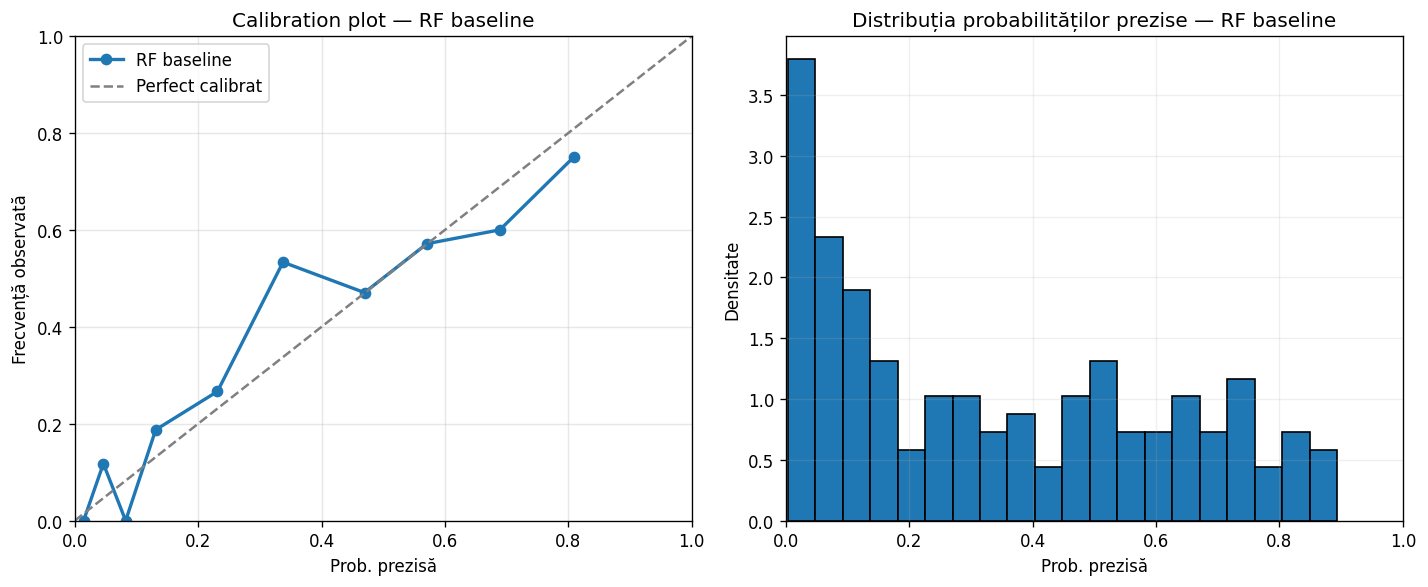

In [ ]:
# Calibrare probabilități pentru RF baseline
prob_true_rf, prob_pred_rf = calibration_curve(
    y_test, proba_rf_base, n_bins=10, strategy="quantile"
)
brier_rf = brier_score_loss(y_test, proba_rf_base)

# ECE pe aceleași bin-uri (quantile)
q = np.linspace(0, 1, 11)
edges = np.quantile(proba_rf_base, q)
bin_idx = np.digitize(proba_rf_base, edges[1:-1], right=True)  # 0..9

ece_terms = []
for b in range(10):
    m = (bin_idx == b)
    if m.sum() == 0:
        continue
    conf = proba_rf_base[m].mean()
    acc  = y_test[m].mean()
    ece_terms.append(m.mean() * abs(acc - conf))
ece_rf = float(np.sum(ece_terms))

print(f"[RF baseline] Brier score (TEST): {brier_rf:.4f}")
print(f"[RF baseline] ECE (quantile bins): {ece_rf:.4f}\n")

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Calibration plot
axes[0].plot(prob_pred_rf, prob_true_rf, marker='o', linewidth=2, label="RF baseline")
axes[0].plot([0,1],[0,1],'--', color='gray', label="Perfect calibrat")
axes[0].set_xlim(0,1); axes[0].set_ylim(0,1)
axes[0].set_xlabel("Prob. prezisă"); axes[0].set_ylabel("Frecvență observată")
axes[0].set_title("Calibration plot — RF baseline")
axes[0].legend(loc="upper left"); axes[0].grid(alpha=0.3)

# Histogramă (densitate)
axes[1].hist(proba_rf_base, bins=20, edgecolor='k', density=True)
axes[1].set_xlim(0,1); axes[1].set_xlabel("Prob. prezisă"); axes[1].set_ylabel("Densitate")
axes[1].set_title("Distribuția probabilităților prezise — RF baseline")
axes[1].grid(alpha=0.2)

plt.tight_layout(); plt.show()


Importanța variabilelor (echivalent coeficienți LR)

,importanta
Glucose,0.2627
BMI,0.1646
Age,0.1270
DiabetesPedigreeFunction,0.1195
Insulin,0.0972
BloodPressure,0.0824
Pregnancies,0.0734
SkinThickness,0.0733


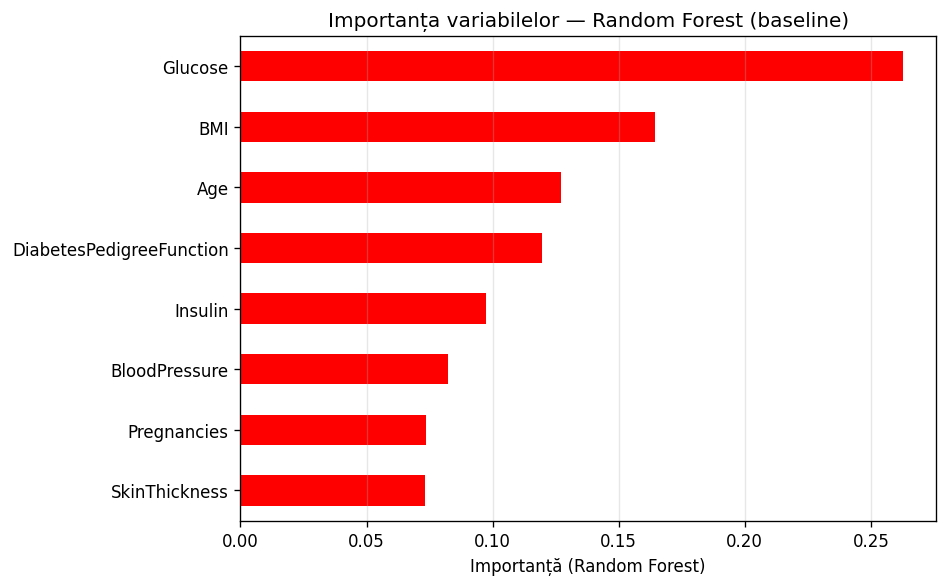

In [ ]:
imp_rf = pd.Series(rf_base.feature_importances_, index=feature_names)

interpretare_rf = (
    pd.DataFrame({
        "importanta": imp_rf
    })
    .reindex(imp_rf.sort_values(ascending=False).index)
    .round(4)
)

display(interpretare_rf)

plt.figure(figsize=(8,5))
valori = interpretare_rf["importanta"].iloc[::-1]
valori.plot(kind="barh", color="red")

plt.xlabel("Importanță (Random Forest)")
plt.title("Importanța variabilelor — Random Forest (baseline)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

Random Forest îmbunătățit: SMOTE + GridSearch

In [ ]:
# folosim X_train_tr, y_train_tr (după SMOTE)

param_dist_rf = {
    "n_estimators": [150, 250, 350],          # mai puține valori
    "max_depth": [None, 4, 6, 8],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

cv_rf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rf_base_model = RandomForestClassifier(
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rand_rf = RandomizedSearchCV(
    rf_base_model,
    param_distributions=param_dist_rf,
    n_iter=25,                 # doar 25 combinații aleatoare, nu toate
    scoring="accuracy",
    cv=cv_rf,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

rand_rf.fit(X_train_tr, y_train_tr)

print("Best params RF:", rand_rf.best_params_,
      "| CV acc:", round(rand_rf.best_score_, 4))

rf_best = rand_rf.best_estimator_
rf_best.fit(X_train_tr, y_train_tr)

proba_rf_best = rf_best.predict_proba(X_test_scl)[:, 1]

print("=== RF + SMOTE (tuned, thr=0.5) ===")
m_rf_best = eval_binary(y_test, proba_rf_best, 0.5, "RF Tuned + SMOTE")


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params RF: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None} | CV acc: 0.825
=== RF + SMOTE (tuned, thr=0.5) ===
RF Tuned + SMOTE
Accuracy=0.7338  Precision=0.6000  Recall=0.7222  F1=0.6555  AUC=0.8081
              precision    recall  f1-score   support

           0     0.8315    0.7400    0.7831       100
           1     0.6000    0.7222    0.6555        54

    accuracy                         0.7338       154
   macro avg     0.7157    0.7311    0.7193       154
weighted avg     0.7503    0.7338    0.7383       154

Confusion matrix:
 [[74 26]
 [15 39]]


Permutation Importance (importanță prin permutare)

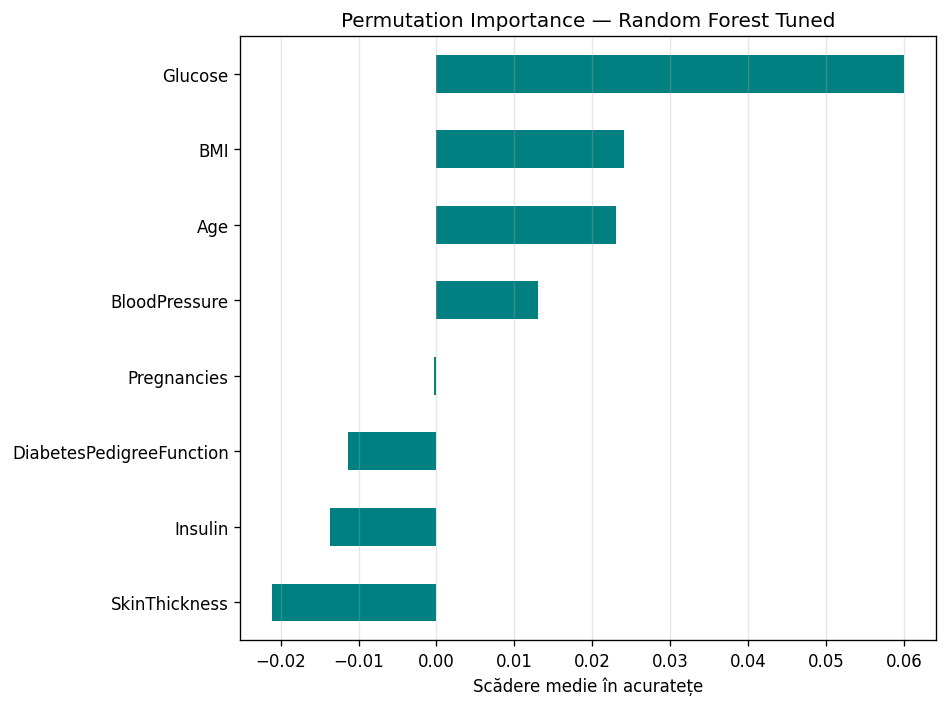


Permutation Importance values:


,importance
Glucose,0.060065
BMI,0.024026
Age,0.023052
BloodPressure,0.012987
Pregnancies,-0.000325
DiabetesPedigreeFunction,-0.011364
Insulin,-0.013636
SkinThickness,-0.021104


In [ ]:
result = permutation_importance(
    rf_best,                # modelul final după GridSearch
    X_test_scl,             # aceleași date pe care ai evaluat modelul
    y_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

perm_importance = pd.Series(result.importances_mean, index=feature_names)
perm_importance = perm_importance.sort_values(ascending=True)

plt.figure(figsize=(8,6))
perm_importance.plot(kind="barh", color="teal")
plt.title("Permutation Importance — Random Forest Tuned")
plt.xlabel("Scădere medie în acuratețe")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPermutation Importance values:")
display(perm_importance.sort_values(ascending=False).to_frame("importance"))

ROC & PR – comparație RF Baseline vs RF Tuned


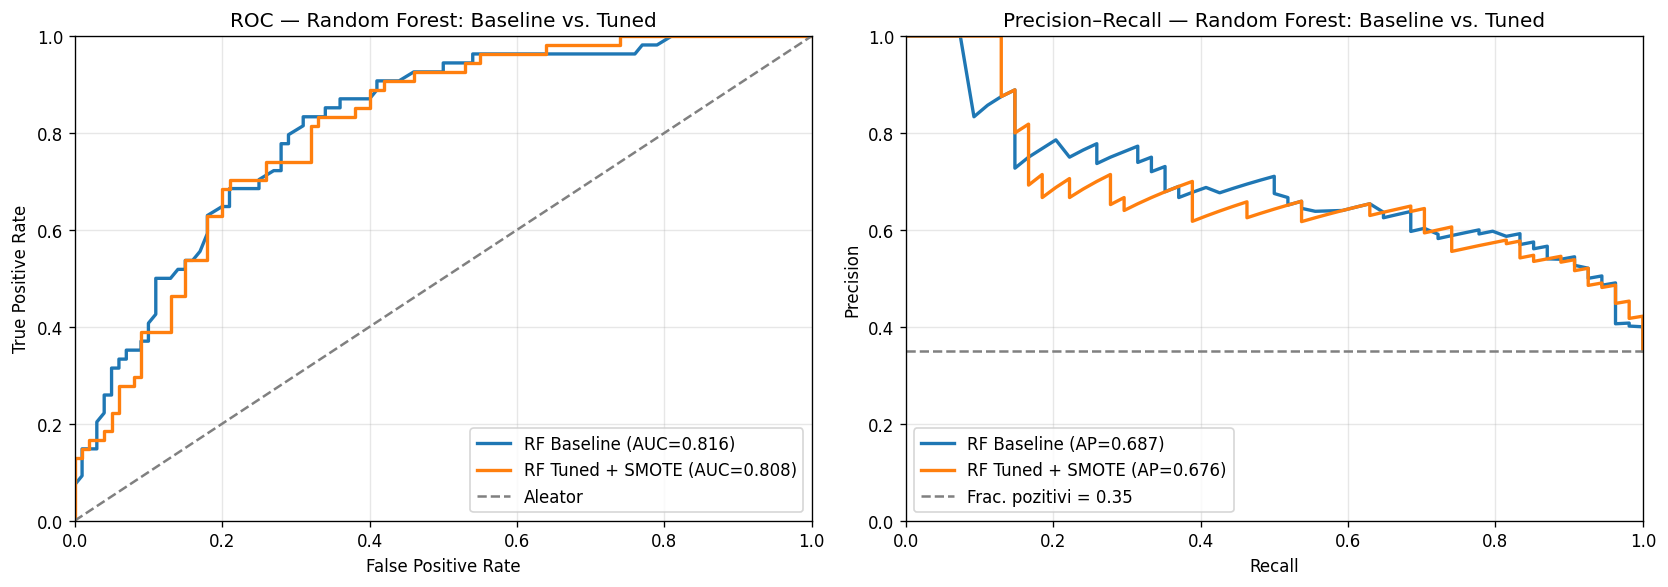

In [ ]:
# dicționarul cu probabilități
models_proba = {
    "RF Baseline": proba_rf_base,
    "RF Tuned + SMOTE": proba_rf_best
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC
ax = axes[0]
for name, proba in models_proba.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc:.3f})")

ax.plot([0, 1], [0, 1], "--", color="gray", label="Aleator")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC — Random Forest: Baseline vs. Tuned")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

# Precision–Recall
ax = axes[1]
baseline = y_test.mean()

for name, proba in models_proba.items():
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    ax.plot(rec, prec, linewidth=2, label=f"{name} (AP={ap:.3f})")

ax.plot([0, 1], [baseline, baseline], "--", color="gray",
        label=f"Frac. pozitivi = {baseline:.2f}")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall — Random Forest: Baseline vs. Tuned")
ax.legend(loc="lower left")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Comparație numerică RF Baseline vs RF Tuned

,Accuracy,Precision,Recall,F1,ROC AUC
RF Baseline,0.7338,0.6383,0.5556,0.5941,0.8158
RF Tuned + SMOTE,0.7338,0.6000,0.7222,0.6555,0.8081


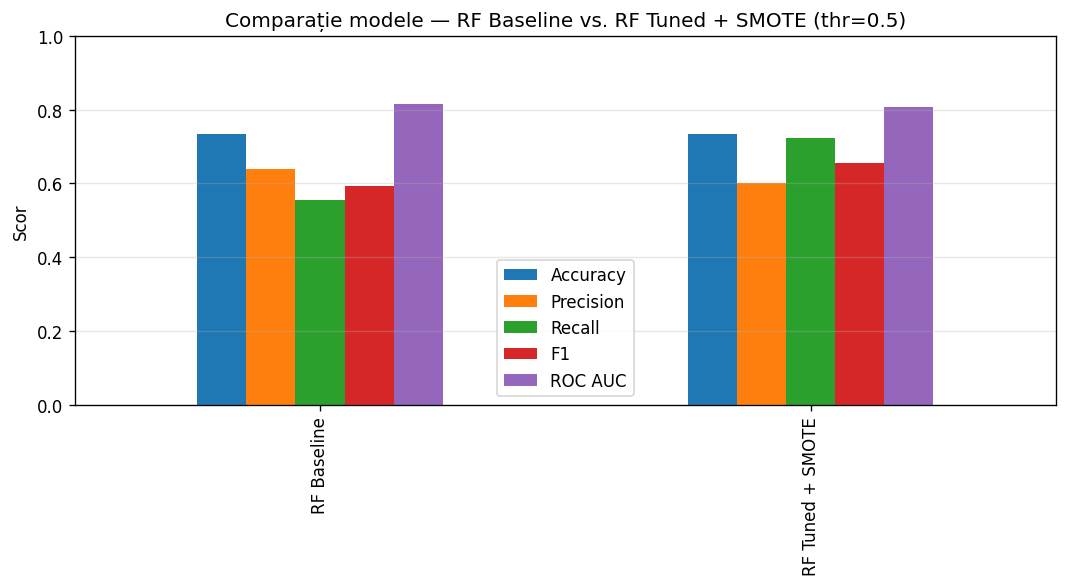

In [ ]:
acc_b  = m_rf_base["acc"];  prec_b = m_rf_base["prec"];  rec_b = m_rf_base["rec"];  f1_b = m_rf_base["f1"];  auc_b = m_rf_base["auc"]
acc_t  = m_rf_best["acc"];  prec_t = m_rf_best["prec"];  rec_t = m_rf_best["rec"];  f1_t = m_rf_best["f1"];  auc_t = m_rf_best["auc"]

comparatie_rf = pd.DataFrame({
    "Accuracy":  [acc_b,  acc_t],
    "Precision": [prec_b, prec_t],
    "Recall":    [rec_b,  rec_t],
    "F1":        [f1_b,   f1_t],
    "ROC AUC":   [auc_b,  auc_t],
}, index=["RF Baseline", "RF Tuned + SMOTE"]).round(4)

display(comparatie_rf)

ax = comparatie_rf.plot(kind="bar", figsize=(9,5))
plt.title("Comparație modele — RF Baseline vs. RF Tuned + SMOTE (thr=0.5)")
plt.ylabel("Scor"); plt.ylim(0,1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

Learning Curve — Random Forest

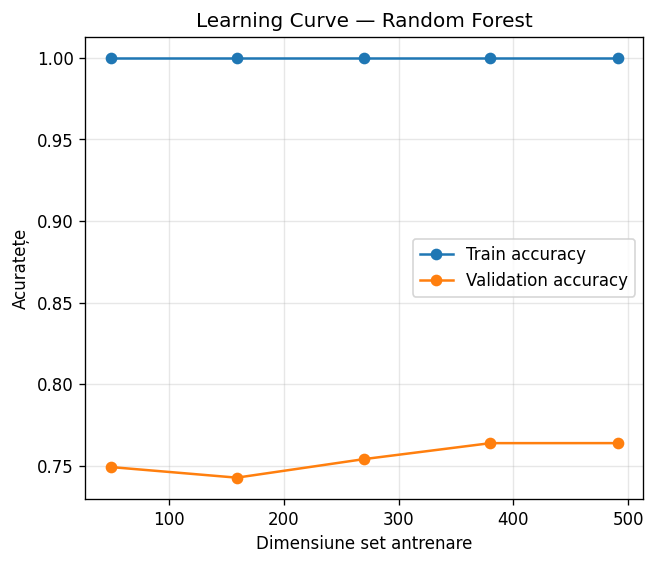

In [ ]:
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    X_train_scl,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean_rf = train_scores_rf.mean(axis=1)
val_mean_rf   = val_scores_rf.mean(axis=1)

plt.figure(figsize=(6,5))
plt.plot(train_sizes_rf, train_mean_rf, 'o-', label="Train accuracy")
plt.plot(train_sizes_rf, val_mean_rf,   'o-', label="Validation accuracy")
plt.xlabel("Dimensiune set antrenare")
plt.ylabel("Acuratețe")
plt.title("Learning Curve — Random Forest")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Histogramă predicții per clasă — RF Tuned

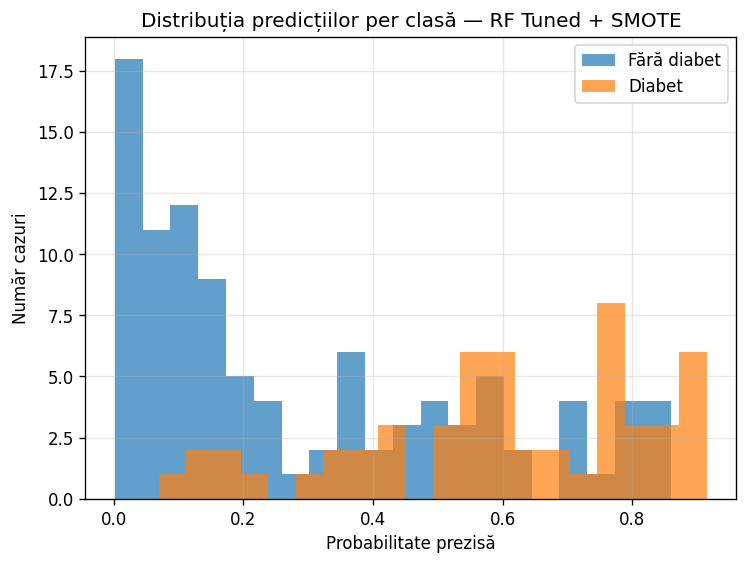

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(proba_rf_best[y_test==0], bins=20, alpha=0.7, label="Fără diabet")
plt.hist(proba_rf_best[y_test==1], bins=20, alpha=0.7, label="Diabet")
plt.xlabel("Probabilitate prezisă")
plt.ylabel("Număr cazuri")
plt.title("Distribuția predicțiilor per clasă — RF Tuned + SMOTE")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Prag optim pe valid (max F1) și aplicare pe test (RF)

In [ ]:
# split valid din TRAIN original (fără scurgere din TEST)
X_tr_sub_rf, X_val_rf, y_tr_sub_rf, y_val_rf = train_test_split(
    X_train_raw, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

# preproc pe sub-train
imp_val_rf = SimpleImputer(strategy="median"); sc_val_rf = StandardScaler()
X_tr_sub_imp_rf = imp_val_rf.fit_transform(X_tr_sub_rf); X_val_imp_rf = imp_val_rf.transform(X_val_rf)
X_tr_sub_scl_rf = sc_val_rf.fit_transform(X_tr_sub_imp_rf); X_val_scl_rf = sc_val_rf.transform(X_val_imp_rf)

# SMOTE pe sub-train
sm_val_rf = SMOTE(random_state=RANDOM_STATE)
X_tr_sub_tr_rf, y_tr_sub_tr_rf = sm_val_rf.fit_resample(X_tr_sub_scl_rf, y_tr_sub_rf)

# re-antrenare RF pe sub-train echilibrat
rf_val = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_val.fit(X_tr_sub_tr_rf, y_tr_sub_tr_rf)
proba_val_rf = rf_val.predict_proba(X_val_scl_rf)[:, 1]

# best threshold (max F1)
prec_v_rf, rec_v_rf, thr_v_rf = precision_recall_curve(y_val_rf, proba_val_rf)
f1_v_rf = 2 * (prec_v_rf * rec_v_rf) / (prec_v_rf + rec_v_rf + 1e-12)
ix_rf = int(np.nanargmax(f1_v_rf))
best_thr_rf = thr_v_rf[ix_rf] if ix_rf < len(thr_v_rf) else 0.5
print(f"[RF] Prag optim (max F1) pe VALIDARE: {best_thr_rf:.4f} | Precision={prec_v_rf[ix_rf]:.4f} Recall={rec_v_rf[ix_rf]:.4f} F1={f1_v_rf[ix_rf]:.4f}")

# aplicăm pragul pe modelul RF Tuned + SMOTE (deja antrenat pe tot train-ul)
pred_test_opt_rf = (proba_rf_best >= best_thr_rf).astype(int)
print("\nEvaluare RF Tuned + SMOTE cu pragul optim:")
print(classification_report(y_test, pred_test_opt_rf, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test_opt_rf))

[RF] Prag optim (max F1) pe VALIDARE: 0.5800 | Precision=0.7143 Recall=0.6977 F1=0.7059

Evaluare RF Tuned + SMOTE cu pragul optim:
              precision    recall  f1-score   support

           0     0.7810    0.8200    0.8000       100
           1     0.6327    0.5741    0.6019        54

    accuracy                         0.7338       154
   macro avg     0.7068    0.6970    0.7010       154
weighted avg     0.7290    0.7338    0.7306       154

Confusion matrix:
 [[82 18]
 [23 31]]


SHAP values

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-2685947333.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


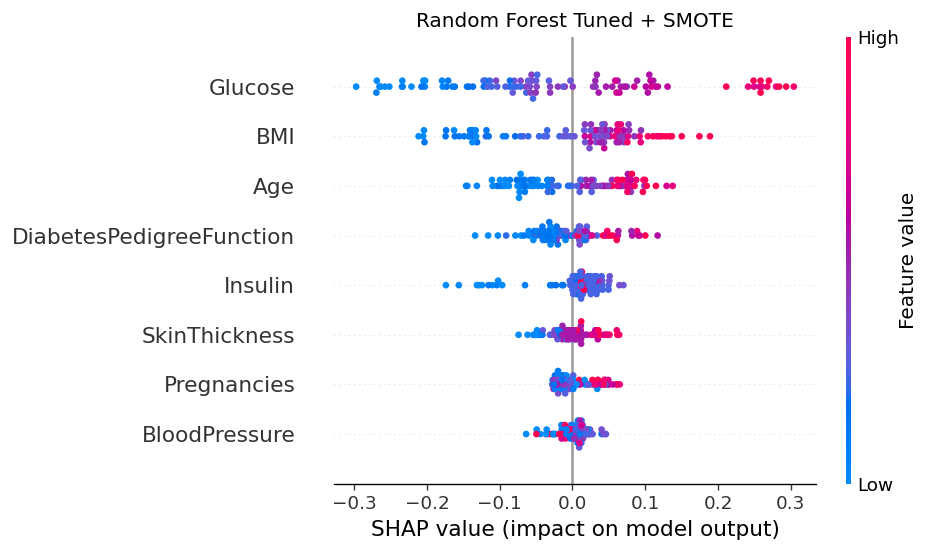

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

# background: subset din X_train_tr (după SMOTE + scalare)
bg_size = min(100, X_train_tr.shape[0])
background_rf = X_train_tr[:bg_size]

# funcția de model: probabilitatea clasei 1 (diabet)
f_rf = lambda X: rf_best.predict_proba(X)[:, 1]

# Explainer pentru RF optim
explainer_rf_opt = shap.KernelExplainer(f_rf, background_rf)

# subset din test (date scalate, fără SMOTE)
n_samples = min(100, X_test_scl.shape[0])
X_test_sample_rf = X_test_scl[:n_samples]

# SHAP values
shap_values_rf_opt = explainer_rf_opt.shap_values(X_test_sample_rf)

# Summary plot pentru RF optim
plt.title("Random Forest Tuned + SMOTE")
shap.summary_plot(
    shap_values_rf_opt,
    X_test_sample_rf,
    feature_names=feature_names,
    show=True
)